In [10]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mne.io import read_raw_edf
from scipy.signal import welch

In [11]:
file_path = "01IS-1-ADP.edf"
raw = read_raw_edf(file_path, preload=True)

sampling_rate = int(raw.info['sfreq'])
signal = raw.get_data(picks="eeg")[0]

Extracting EDF parameters from /media/artem/data/Dev/Sleep_analysis/01IS-1-ADP.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7529215  =      0.000 ... 29410.996 secs...


In [12]:
time_period_in_seconds = 20
analysis_windows = sampling_rate * time_period_in_seconds
print(f"time period: {time_period_in_seconds}seconds")

time period: 20seconds


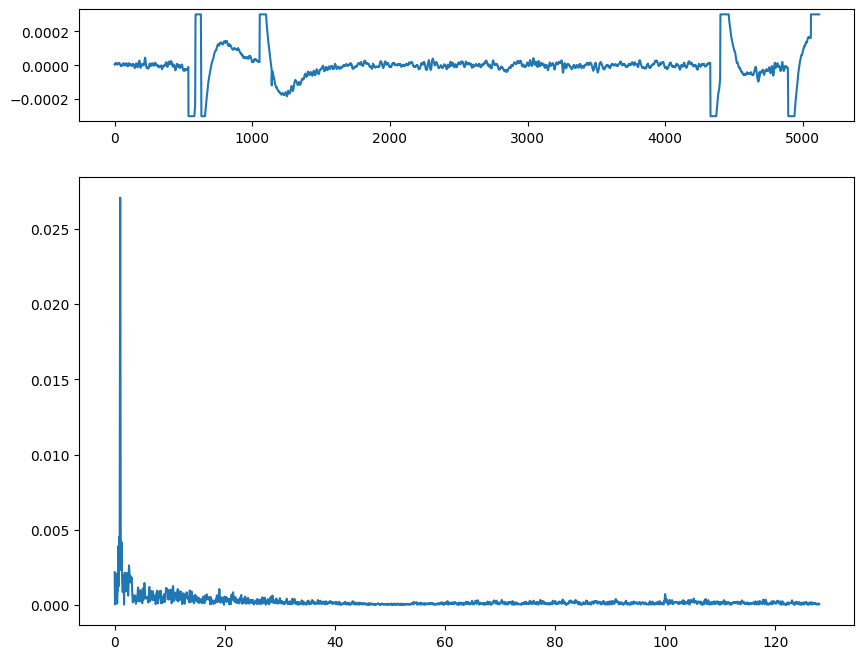

In [13]:
from matplotlib import gridspec
from fft_func import compute_frequency_analysis_for_a_period


def compute_graph_for_a_period(signal, windows_lenght, sampling_rate, period=0):
    start = windows_lenght * period
    end = start + windows_lenght

    fft_result = compute_frequency_analysis_for_a_period(signal, windows_lenght, sampling_rate, period=0)

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    ax0.plot(signal[start:end])
    ax1.plot(fft_result.keys(), fft_result.values())

    plt.show()


compute_graph_for_a_period(signal=signal,
                           sampling_rate=sampling_rate,
                           windows_lenght=analysis_windows,
                           period=52)


In [14]:
import ipywidgets as widgets
from ipywidgets import interact

def interactive_plot():
    period_slider = widgets.IntSlider(value=52, min=0, max=len(signal) // analysis_windows - 1, step=1, description="Period:")
    interact(compute_graph_for_a_period, signal=widgets.fixed(signal),
             sampling_rate=widgets.fixed(sampling_rate),
             windows_lenght=widgets.fixed(analysis_windows),
             period=period_slider)


interactive_plot()

interactive(children=(IntSlider(value=52, description='Period:', max=1469), Output()), _dom_classes=('widget-i…